In [50]:


get_ipython().run_line_magic('load_ext', 'autoreload')
get_ipython().run_line_magic('autoreload', '2')

import torch
import pandas as pd, psycopg2, os
from sklearn.preprocessing import StandardScaler
from sklearn.isotonic import IsotonicRegression
import numpy as np  
import torch
from torch.utils.data import Dataset, DataLoader
import joblib
import torch.nn as nn
import datetime as dt
from dotenv import load_dotenv
import matplotlib.pyplot as plt
# --- TensorBoard ---
from torch.utils.tensorboard import SummaryWriter
import time
from BoatRaceDataset2 import BoatRaceDataset     # ← MTL 対応版
import itertools

# --- reproducibility helpers ---
import random  # reproducibility helpers

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# ----------------------------------------------------------------------
# Feature‑engineering registry (declarative “add / drop” infrastructure)
# ----------------------------------------------------------------------
from dataclasses import dataclass, field
from typing import Callable, Sequence, Dict
import pandas as pd  # already imported above, but kept for clarity

@dataclass
class FeatureDef:
    """Declarative feature definition."""
    name: str
    fn: Callable[[pd.DataFrame], pd.Series]
    deps: Sequence[str] = field(default_factory=tuple)  # for documentation
    dtype: str = None                            # optional cast

FEATURE_REGISTRY: Dict[str, FeatureDef] = {}

def register_feature(fd: FeatureDef):
    """Add a feature definition to the global registry."""
    FEATURE_REGISTRY[fd.name] = fd

def apply_features(
    df: pd.DataFrame,
    include: Sequence[str] = None,
    exclude: Sequence[str] = None,
    inplace: bool = False,
) -> pd.DataFrame:
    """
    Materialise features declared in the registry.

    Parameters
    ----------
    df : DataFrame
        Source dataframe.
    include / exclude : list[str] | None
        White‑/black‑lists of feature names.  `include=None` means “all”.
    inplace : bool
        If False (default), work on a copy to avoid side‑effects.
    """
    if not inplace:
        df = df.copy()

    names = include if include is not None else list(FEATURE_REGISTRY)
    if exclude:
        names = [n for n in names if n not in exclude]

    for n in names:
        fd = FEATURE_REGISTRY[n]
        df[n] = fd.fn(df)
        if fd.dtype:
            df[n] = df[n].astype(fd.dtype)
    return df

# --------------------------- default features --------------------------
def _wind_sin(df: pd.DataFrame) -> pd.Series:
    """Sine of wind direction (deg → rad)."""
    return np.sin(np.deg2rad(df["wind_dir_deg"]))

def _wind_cos(df: pd.DataFrame) -> pd.Series:
    """Cosine of wind direction (deg → rad)."""
    return np.cos(np.deg2rad(df["wind_dir_deg"]))

register_feature(FeatureDef("wind_sin", _wind_sin, deps=["wind_dir_deg"]))
register_feature(FeatureDef("wind_cos", _wind_cos, deps=["wind_dir_deg"]))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [69]:


import nbformat
from nbconvert import PythonExporter

with open("main3.ipynb", "r", encoding="utf-8") as f:
    nb = nbformat.read(f, as_version=4)

exporter = PythonExporter()
source, _ = exporter.from_notebook_node(nb)

with open("main3.py", "w", encoding="utf-8") as f:
    f.write(source)

In [52]:


load_dotenv(override=True)

DB_CONF = {
    "host":     os.getenv("PGHOST", "localhost"),
    "port":     int(os.getenv("PGPORT", 5432)),
    "dbname":   os.getenv("PGDATABASE", "boatrace"),
    "user":     os.getenv("PGUSER", "br_user"),
    "password": os.getenv("PGPASSWORD", "secret"),
}

# ------------------------------------------------------------------
# DB 接続
# ------------------------------------------------------------------
conn = psycopg2.connect(**DB_CONF)
df = pd.read_sql("""
    SELECT * FROM feat.train_features3
    WHERE race_date <= '2024-12-31'
""", conn)


print(f"Loaded {len(df)} rows from the database.")

# # ------------------------------------------------------------------
# # Low‑cost performance boost:
# # 30‑day rolling stats per racer (starts, win‑rate, etc.)
# # ------------------------------------------------------------------
# try:
#     hist30 = pd.read_sql("SELECT * FROM feat.racer_hist_30d", conn)
#     # add lane‑specific suffixes and left‑join for every lane
#     for lane in range(1, 7):
#         df = df.merge(
#             hist30.add_suffix(f"_l{lane}"),            # e.g. starts_30d_l1
#             how="left",
#             left_on=f"lane{lane}_racer_id",
#             right_on=f"racer_id_l{lane}"
#         )
#     print(f"[info] merged 30‑day stats ‑ new shape: {df.shape}")
# except Exception as e:
#     # keep pipeline running even if the view is missing
#     print("[warn] 30‑day stats merge skipped:", e)

/var/folders/9n/_65_h0_d791gcmmvjcjjkn9r0000gn/T/ipykernel_83961/1498121936.py:15: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql("""


Loaded 6638 rows from the database.


In [53]:


# --- 追加特徴量（Feature Registry 経由） ---
df = apply_features(df)

exclude = []

# for lane in range(1, 7):
#       # --- 対象列を決める（ターゲット & キー列は除外） ---
#       exclude.append(
#             f"lane{lane}_st",
#       )

df.drop(columns=exclude, inplace=True, errors="ignore")


# numeric columns for StandardScaler
BASE_NUM_COLS = ["air_temp", "wind_speed", "wave_height",
                 "water_temp", "wind_sin", "wind_cos"]
# automatically pick up newly merged rolling features (suffix *_30d)
HIST_NUM_COLS = [c for c in df.columns
                 if c.endswith("_30d") and df[c].dtype != "object"]
NUM_COLS = BASE_NUM_COLS + HIST_NUM_COLS
print(f"[info] StandardScaler will use {len(NUM_COLS)} numeric cols "
      f"({len(BASE_NUM_COLS)} base + {len(HIST_NUM_COLS)} hist)")
scaler = StandardScaler().fit(df[NUM_COLS])
df[NUM_COLS] = scaler.transform(df[NUM_COLS])

bool_cols = [c for c in df.columns if c.endswith("_fs_flag")]
df[bool_cols] = df[bool_cols].fillna(False).astype(bool)

# rank_cols = [f"lane{l}_rank" for l in range(1, 7)]
# df[rank_cols] = df[rank_cols].fillna(7).astype("int32")
df.to_csv("artifacts/train_features.csv", index=False)
display(df.head())
print("データフレーム全体の欠損値の総数:", df.isnull().sum().sum())

# 各列の欠損値の割合を表示（0〜1の値）
missing_ratio = df.isnull().mean()

# パーセント表示にする場合（見やすさのため）
missing_ratio_percent = missing_ratio * 100

print("各列の欠損値の割合（%）:")
print(missing_ratio_percent.sort_values(ascending=False))

os.makedirs("artifacts", exist_ok=True)
scaler_filename = "artifacts/wind_scaler.pkl"
joblib.dump(scaler, scaler_filename)

[info] StandardScaler will use 6 numeric cols (6 base + 0 hist)


/var/folders/9n/_65_h0_d791gcmmvjcjjkn9r0000gn/T/ipykernel_83961/4048383080.py:28: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[bool_cols] = df[bool_cols].fillna(False).astype(bool)


,race_key,race_date,venue,air_temp,wind_speed,wave_height,water_temp,weather_txt,wind_dir_deg,lane1_racer_id,...,lane5_first_rate,lane5_two_rate,lane5_three_rate,lane6_starts,lane6_firsts,lane6_first_rate,lane6_two_rate,lane6_three_rate,wind_sin,wind_cos
0,若松_20220101_1,2022-01-01,若松,-1.906512,-1.587881,-1.154597,-1.238742,晴,NaN,5104,...,0.153846,0.307692,0.461538,17.0,1.0,0.058824,0.117647,0.176471,NaN,NaN
1,若松_20220101_10,2022-01-01,若松,-1.782125,-1.587881,-1.154597,-1.238742,晴,NaN,3576,...,0.000000,0.000000,0.333333,11.0,1.0,0.090909,0.090909,0.181818,NaN,NaN
2,若松_20220101_11,2022-01-01,若松,-1.782125,-1.587881,-1.154597,-1.238742,晴,NaN,4371,...,0.225806,0.419355,0.451613,7.0,1.0,0.142857,0.285714,0.714286,NaN,NaN
3,若松_20220101_12,2022-01-01,若松,-1.906512,-1.587881,-1.154597,-1.238742,晴,NaN,4765,...,0.066667,0.133333,0.266667,12.0,0.0,0.000000,0.083333,0.166667,NaN,NaN
4,若松_20220101_2,2022-01-01,若松,-1.533351,-0.498082,-0.575465,-1.238742,晴,22.5,4204,...,0.000000,0.000000,0.000000,68.0,1.0,0.014706,0.176471,0.426471,0.042607,1.243043


データフレーム全体の欠損値の総数: 2818
各列の欠損値の割合（%）:
wind_cos          7.984333
wind_sin          7.984333
wind_dir_deg      7.984333
lane3_st          0.873757
lane5_st          0.843628
                    ...   
lane5_rank        0.000000
lane6_racer_id    0.000000
lane1_rank        0.000000
lane1_racer_id    0.000000
race_key          0.000000
Length: 95, dtype: float64


['artifacts/wind_scaler.pkl']

In [54]:


def encode(col):
    uniq = sorted(df[col].dropna().unique())
    mapping = {v:i for i,v in enumerate(uniq)}
    df[col + "_id"] = df[col].map(mapping).fillna(-1).astype("int16")
    return mapping
venue2id = encode("venue")
# race_type2id = encode("race_type")

In [55]:


# ============================================================
# 0) ── データの“ラベル & 特徴量”を 1 行だけ覗く可視化 Snippet
#      ★★ ここは notebook なら「1 セルだけ」実行すれば OK ★★
# ------------------------------------------------------------
def peek_one(df: pd.DataFrame, seed: int = 0) -> None:
    """
    ランダムに 1 レース（1 行）だけ抜き取り、順位と主要特徴量を一覧表示
    """
    row = df.sample(1, random_state=seed).squeeze()

    def lane_list(prefix: str):
        return [row[f"lane{i}_{prefix}"] for i in range(1, 7)]

    print("── sample race ──")
    print("rank    :", lane_list("rank"))
    print("exh_time:", lane_list("exh_time"))
    print("st      :", lane_list("st"))
    print("fs_flag :", lane_list("fs_flag"))
    print("weight  :", lane_list("weight"))

# ---------------------------------------------
# ここで一度だけ呼んで目視確認しておくとズレにすぐ気付けます
peek_one(df)
# ============================================================


LANE_DIM = 8
# ---------------- Loss / Regularization Weights -----------------
LAMBDA_ST = 0.1      # weight for ST‑MSE  (was 0.3)
L1_ALPHA  = 0.02     # weight for rank‑L1 loss
CLIP_NORM = 10.0     # gradient‑clipping threshold (was 5.0)
RANKNET_ALPHA = 0.10   # weight for pairwise RankNet loss
TEMPERATURE   = 0.80   # logits are divided by T at inference
LAMBDA_WIN = 1.0        # weight for winner‑BCE loss

class DualHeadRanker(nn.Module):
    """
    ctx(6) + boat(6) → lane ごとにスコア 1 個
    """
    def __init__(self, ctx_in=6, boat_in=6, hidden=160, lane_dim=LANE_DIM):
        super().__init__()
        self.lane_emb = nn.Embedding(6, lane_dim)
        self.ctx_fc   = nn.Linear(ctx_in, hidden)
        self.boat_fc  = nn.Linear(boat_in + lane_dim, hidden)
        self.head_rank = nn.Sequential(
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, 1)
        )
        self.head_st = nn.Sequential(
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, 1)
        )
        self.head_win = nn.Sequential(
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, 1)
        )

        # 重み初期化を対称性ブレイク用に Xavier で揃える
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, ctx, boats, lane_ids):  # boats:(B,6,4) lane_ids:(B,6)
        B, L, _ = boats.size()
        ctx_emb  = self.ctx_fc(ctx)          # (B,h)

        if lane_ids.dim() == 1:
            lane_ids = lane_ids.unsqueeze(1).expand(-1, L)
        elif lane_ids.dim() == 2 and lane_ids.size(1) == 1:
            lane_ids = lane_ids.expand(-1, L)
        lane_ids = lane_ids.contiguous()

        lane_emb = self.lane_emb(lane_ids)   # (B,6,lane_dim)
        boat_inp = torch.cat([boats, lane_emb], dim=-1)
        boat_emb = self.boat_fc(boat_inp)    # (B,6,h)

        h = torch.tanh(ctx_emb.unsqueeze(1) + boat_emb)  # (B,6,h)

        st_pred   = self.head_st(h).squeeze(-1)     # (B,6)
        rank_pred = self.head_rank(h).squeeze(-1)   # (B,6)
        win_logits = self.head_win(h).squeeze(-1)   # (B,6)
        return st_pred, rank_pred, win_logits

# --- alias for legacy references ---
SimpleCPLNet = DualHeadRanker



── sample race ──
rank    : [np.int64(1), np.int64(2), np.int64(4), np.int64(5), np.int64(3), np.int64(6)]
exh_time: [np.float64(6.86), np.float64(6.92), np.float64(6.95), np.float64(6.9), np.float64(6.92), np.float64(6.97)]
st      : [np.float64(0.13), np.float64(0.09), np.float64(0.11), np.float64(0.12), np.float64(0.12), np.float64(0.17)]
fs_flag : [np.False_, np.True_, np.True_, np.True_, np.False_, np.True_]
weight  : [np.float64(51.0), np.float64(52.0), np.float64(54.2), np.float64(53.7), np.float64(52.0), np.float64(55.1)]


In [56]:


def pl_nll(scores: torch.Tensor, ranks: torch.Tensor, reduce: bool = True) -> torch.Tensor:
    """
    Plackett‑Luce negative log‑likelihood.

    Parameters
    ----------
    scores : (B,6)  lane scores (higher = better)
    ranks  : (B,6)  1=1st … 6=6th   (smaller = better)
    reduce : bool   If True (default) return mean over batch.
                    If False, return per‑sample loss vector (B,).

    Notes
    -----
    Adopts log‑sum‑exp trick for numerical stability.
    """
    scores = scores.clamp(-20.0, 20.0)        # avoid Inf/NaN

    order = torch.argsort(ranks, dim=1)       # (B,6) winner→last
    nll = torch.zeros(scores.size(0), device=scores.device)
    s = scores.clone()

    for pos in range(6):
        log_denom = torch.logsumexp(s, dim=1)                 # (B,)
        idx = order[:, pos]                                   # (B,)
        chosen = s.gather(1, idx.unsqueeze(1)).squeeze(1)     # (B,)
        nll += log_denom - chosen
        s = s.scatter(1, idx.unsqueeze(1), float('-inf'))

    return nll.mean() if reduce else nll

# --- Pairwise RankNet loss ---
def ranknet_loss(scores: torch.Tensor, ranks: torch.Tensor) -> torch.Tensor:
    """
    Pairwise RankNet loss (cross‑entropy on all lane pairs).
    ranks : (B,6) with 1=best … 6=worst.
    """
    pair_idx = list(itertools.combinations(range(6), 2))
    loss_acc = 0.0
    for i, j in pair_idx:
        S_ij = torch.sign(ranks[:, j] - ranks[:, i])  # +1 if i<j (i better)
        diff = scores[:, i] - scores[:, j]
        loss_acc += torch.nn.functional.softplus(-S_ij * diff).mean()
    return loss_acc / len(pair_idx)

# ── pl_nll が正しいか 3 秒で判定 ──
scores = torch.tensor([[6, 5, 4, 3, 2, 1]], dtype=torch.float32)  # lane0 が最強
ranks  = torch.tensor([[1, 2, 3, 4, 5, 6]], dtype=torch.int64)    # lane0 が 1 着
print("pl_nll should be ~0 :", pl_nll(scores, ranks).item())

pl_nll should be ~0 : 2.0691652297973633


In [57]:


df["race_date"] = pd.to_datetime(df["race_date"]).dt.date
latest_date = df["race_date"].max()
cutoff = latest_date - dt.timedelta(days=90)

mode = "diff"  # "raw", "log", "zscore" も試せる
ds_train = BoatRaceDataset(df[df["race_date"] <  cutoff])
ds_val   = BoatRaceDataset(df[df["race_date"] >= cutoff])

loader_train = DataLoader(ds_train, batch_size=256, shuffle=True)
loader_val   = DataLoader(ds_val,   batch_size=512)

# ------------------- ⑤ 学習ループ（LR↓ + Clip） --------------
device = "cuda" if torch.cuda.is_available() else "cpu"
boat_dim = ds_train.boat_dim
model = DualHeadRanker(boat_in=boat_dim).to(device)
opt = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=5e-5)

In [65]:


# # ------------------------- quick diagnostics --------------------------
# # Set RUN_DIAG = True to automatically run:
# #   A) learning‑curve vs. data fraction
# #   B) tiny‑set over‑fit test
# # Diagnostics run *once* before the main training loop.

def evaluate_model(model, dataset, device):
    model.eval()
    loader = DataLoader(dataset, batch_size=512)
    total_loss = 0
    with torch.no_grad():
        # 6 要素を受け取り、ST は無視
        for ctx, boats, lane_ids, ranks, *_ in loader:
            ctx, boats = ctx.to(device), boats.to(device)
            lane_ids, ranks = lane_ids.to(device), ranks.to(device)

            _, scores, _ = model(ctx, boats, lane_ids)   # ST & win logits are ignored
            loss = pl_nll(scores, ranks)
            total_loss += loss.item() * len(ctx)
    return total_loss / len(dataset)


# def run_experiment(data_frac, df_full, mode="zscore", epochs=5, device="cpu"):
#     df_frac = df_full.sample(frac=data_frac, random_state=42)
#     df_frac["race_date"] = pd.to_datetime(df_frac["race_date"]).dt.date
#     latest_date = df_frac["race_date"].max()
#     cutoff = latest_date - dt.timedelta(days=90)  # last 3 months used as validation set
#     ds_train = BoatRaceDataset(df_frac[df_frac["race_date"] < cutoff])
#     ds_val = BoatRaceDataset(df_frac[df_frac["race_date"] >= cutoff])

#     loader_train = DataLoader(ds_train, batch_size=256, shuffle=True)
#     loader_val = DataLoader(ds_val, batch_size=512)

#     boat_dim = ds_train.boat_dim
#     model = DualHeadRanker(boat_in=boat_dim).to(device)
#     opt = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=5e-5)

#     for epoch in range(epochs):
#         model.train()
#         for ctx, boats, lane_ids, ranks, *_ in loader_train:
#             ctx, boats = ctx.to(device), boats.to(device)
#             lane_ids, ranks = lane_ids.to(device), ranks.to(device)

#             _, scores, _ = model(ctx, boats, lane_ids)        # discard ST & win head
#             loss = (pl_nll(scores, ranks, reduce=False) *
#                     torch.where(ranks[:,0]==1,
#                                 torch.tensor(1.0, device=ranks.device),
#                                 torch.tensor(1.5, device=ranks.device))).mean()
#             opt.zero_grad(); loss.backward(); opt.step()

#     train_loss = evaluate_model(model, ds_train, device)
#     val_loss = evaluate_model(model, ds_val, device)
#     return train_loss, val_loss

# # 学習曲線の描画
# def plot_learning_curve(df, device):
#     data_fracs = [0.01, 0.05, 0.1, 0.2, 0.5, 1.0]
#     results = []

#     for frac in data_fracs:
#         tr_loss, val_loss = run_experiment(frac, df, device=device)
#         print(f"Data frac {frac:.2f} → Train: {tr_loss:.4f} / Val: {val_loss:.4f}")
#         results.append((frac, tr_loss, val_loss))

#     fracs, tr_losses, val_losses = zip(*results)
#     plt.plot(fracs, tr_losses, label="Train Loss")
#     plt.plot(fracs, val_losses, label="Val Loss")
#     plt.xlabel("Training Data Fraction")
#     plt.ylabel("Loss")
#     plt.title("Learning Curve")
#     plt.legend()
#     plt.grid(True)
#     plt.show()

# def overfit_tiny(df: pd.DataFrame, device: str = "cpu"):
#     """
#     データセットを 10 行だけに縮小し、500 step で過学習できるか検証
#     """
#     tiny_df = df.sample(10, random_state=1).reset_index(drop=True)
#     tiny_ds = BoatRaceDataset(tiny_df)
#     tiny_loader = DataLoader(tiny_ds, batch_size=10, shuffle=True)

#     net = DualHeadRanker().to(device)
#     opt = torch.optim.AdamW(net.parameters(), lr=3e-3)

#     for _ in range(500):
#         ctx, boats, lane_ids, ranks, st_true, st_mask = next(iter(tiny_loader))
#         ctx, boats = ctx.to(device), boats.to(device)
#         lane_ids, ranks = lane_ids.to(device), ranks.to(device)
#         st_true, st_mask = st_true.to(device), st_mask.to(device)
#         st_pred, scores, _ = net(ctx, boats, lane_ids)
#         pl_loss = (pl_nll(scores, ranks, reduce=False) *
#                    torch.where(ranks[:,0]==1,
#                                torch.tensor(1.0, device=ranks.device),
#                                torch.tensor(1.5, device=ranks.device))).mean()
#         mse_st = ((st_pred - st_true) ** 2 * st_mask.float()).sum() / st_mask.float().sum()
#         loss = pl_loss + LAMBDA_ST * mse_st
#         opt.zero_grad(); loss.backward(); opt.step()

#     print("[tiny] final loss:", loss.item())

# RUN_DIAG = True

# if RUN_DIAG:
#     print("[diag] Running learning‑curve vs. data fraction …")
#     plot_learning_curve(df, device)
#     print("[diag] Running 10‑row overfit_tiny() …")
#     overfit_tiny(df, device)
#     print("[diag]   ► finished quick diagnostics\n")

In [59]:


# ---------------------------------------------------------------------
# print(f"train: {len(ds_train)}  val: {len(ds_val)}"

EPOCHS = 20
# --- TensorBoard setup ---
log_dir = os.path.join("artifacts", "tb", time.strftime("%Y%m%d-%H%M%S"))
os.makedirs(log_dir, exist_ok=True)
writer = SummaryWriter(log_dir=log_dir)
for epoch in range(EPOCHS):
    if epoch == 0:                  # 1 エポック目だけ試す例
        ctx, boats, lane_ids, ranks, st_true, st_mask = next(iter(loader_train))
        ctx, boats = ctx.to(device), boats.to(device)
        lane_ids = lane_ids.to(device)
        st_true, st_mask = st_true.to(device), st_mask.to(device)

        st_pred, scores, win_logits = model(ctx, boats, lane_ids)
        (st_pred.sum() + scores.sum() + win_logits.sum()).backward()     # ダミー backward
        grad_norm = sum(p.grad.abs().mean().item() for p in model.parameters())
        # print(f"[debug] average |grad| = {grad_norm:.3e}")
    # ---- train ----
    model.train(); tr_sum = 0
    grad_sum, grad_steps = 0.0, 0
    for ctx, boats, lane_ids, ranks, st_true, st_mask in loader_train:
        ctx, boats = ctx.to(device), boats.to(device)
        lane_ids, ranks = lane_ids.to(device), ranks.to(device)
        st_true, st_mask = st_true.to(device), st_mask.to(device)

        st_pred, scores, win_logits = model(ctx, boats, lane_ids)
        loss_each = pl_nll(scores, ranks, reduce=False)             # (B,)
        sample_weight = torch.where(ranks[:, 0] == 1,               # lane1 winner?
                                    torch.tensor(1.0, device=ranks.device),
                                    torch.tensor(1.5, device=ranks.device))
        pl_loss = (loss_each * sample_weight).mean()
        mse_st = ((st_pred - st_true) ** 2 * st_mask.float()).sum() / st_mask.float().sum()
        pred_rank = scores.argsort(dim=1, descending=True).argsort(dim=1) + 1  # 1〜6 着になるよう変換
        l1_loss = nn.L1Loss()(pred_rank.float(), ranks.float())
        rn_loss = ranknet_loss(scores, ranks)
        winner_true = (ranks == 1).float()            # one‑hot (B,6)
        bce_win = nn.BCEWithLogitsLoss()(win_logits, winner_true)
        loss = pl_loss + LAMBDA_ST * mse_st + L1_ALPHA * l1_loss + \
               RANKNET_ALPHA * rn_loss + LAMBDA_WIN * bce_win
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), CLIP_NORM)  # ★勾配爆発対策★
        opt.step()

        # ---- gradient magnitude tracking ----
        g_tot, g_cnt = 0.0, 0
        for p in model.parameters():
            if p.grad is not None:
                g_tot += p.grad.detach().abs().mean().item()
                g_cnt += 1
        grad_sum += g_tot / max(g_cnt, 1)
        grad_steps += 1

        tr_sum += loss.item() * len(ctx)

    tr_nll = tr_sum / len(loader_train.dataset)

    # ---- validation ----
    model.eval(); val_sum = 0
    # --- validation: also compute st MSE/MAE
    mse_st_accum, mae_st_accum, n_st = 0.0, 0.0, 0.0
    with torch.no_grad():
        for ctx, boats, lane_ids, ranks, st_true, st_mask in loader_val:
            ctx, boats = ctx.to(device), boats.to(device)
            lane_ids, ranks = lane_ids.to(device), ranks.to(device)
            st_true, st_mask = st_true.to(device), st_mask.to(device)
            st_pred, scores, _ = model(ctx, boats, lane_ids)
            pl_loss = pl_nll(scores, ranks)
            # ST MSE
            mse_st = ((st_pred - st_true) ** 2 * st_mask.float()).sum() / st_mask.float().sum()
            # ST MAE
            abs_err = (st_pred - st_true).abs() * st_mask.float()
            mae_st = abs_err.sum() / st_mask.float().sum()
            # accumulate for epoch
            mse_st_accum += ( ((st_pred - st_true) ** 2) * st_mask.float() ).sum().item()
            mae_st_accum += abs_err.sum().item()
            n_st += st_mask.float().sum().item()
            pred_rank = scores.argsort(dim=1, descending=True).argsort(dim=1) + 1
            l1_loss = nn.L1Loss()(pred_rank.float(), ranks.float())
            rn_loss = ranknet_loss(scores, ranks)
            total = pl_loss + LAMBDA_ST * mse_st + L1_ALPHA * l1_loss + RANKNET_ALPHA * rn_loss
            val_sum += total.item() * len(ctx)

    val_nll = val_sum / len(loader_val.dataset)
    # epoch-wise st metrics
    st_mse_val = mse_st_accum / n_st if n_st > 0 else float('nan')
    st_mae_val = mae_st_accum / n_st if n_st > 0 else float('nan')

    avg_grad = grad_sum / max(grad_steps, 1)
    writer.add_scalar("diag/avg_grad", avg_grad, epoch)
    print(f"epoch {epoch:2d}  train_nll {tr_nll:.4f}  val_nll {val_nll:.4f}  |grad| {avg_grad:.2e}")
    print(f"ST MSE: {st_mse_val:.4f}  ST MAE: {st_mae_val:.4f}")

    # ---- accuracy & 三連単的中率 ----
    def top1_accuracy(scores, ranks):
        pred_top1 = scores.argmax(dim=1)
        true_top1 = (ranks == 1).nonzero(as_tuple=True)[1]
        return (pred_top1 == true_top1).float().mean().item()

    def trifecta_hit_rate(scores, ranks):
        """
        三連単的中率（予測スコア上位3頭の順番が、実際の1〜3着と完全一致する割合）
        """
        pred_top3 = torch.topk(scores, k=3, dim=1).indices
        true_top3 = torch.topk(-ranks, k=3, dim=1).indices  # 小さい順に1〜3着
        hit = [p.tolist() == t.tolist() for p, t in zip(pred_top3, true_top3)]
        return sum(hit) / len(hit)

    # accuracy 評価
    model.eval(); all_scores, all_ranks = [], []
    with torch.no_grad():
        for ctx, boats, lane_ids, ranks, _, _ in loader_val:
            ctx, boats = ctx.to(device), boats.to(device)
            lane_ids = lane_ids.to(device)
            _, scores, _ = model(ctx, boats, lane_ids)
            all_scores.append(scores.cpu())
            all_ranks.append(ranks)

    all_scores = torch.cat(all_scores, dim=0)
    all_ranks = torch.cat(all_ranks, dim=0)

    acc_top1 = top1_accuracy(all_scores, all_ranks)
    acc_tri3 = trifecta_hit_rate(all_scores, all_ranks)
    writer.add_scalar("loss/train_nll",  tr_nll,  epoch)
    writer.add_scalar("loss/val_nll",    val_nll, epoch)
    writer.add_scalar("acc/top1",        acc_top1, epoch)
    writer.add_scalar("acc/trifecta_hit", acc_tri3, epoch)
    # --- ST metrics to TensorBoard
    writer.add_scalar("st/mse", st_mse_val, epoch)
    writer.add_scalar("st/mae", st_mae_val, epoch)

    # --- スコア分散と三連単ランク分析 ---
    def score_confidence_analysis(scores: torch.Tensor) -> torch.Tensor:
        return scores.var(dim=1)

    def get_trifecta_rank(scores: torch.Tensor, true_ranks: torch.Tensor) -> list:
        from itertools import permutations
        B = scores.size(0)
        results = []

        for b in range(B):
            score = scores[b]
            true_rank = true_ranks[b]
            true_top3 = [i for i, r in enumerate(true_rank.tolist()) if r <= 3]
            true_top3_sorted = [x for _, x in sorted(zip(true_rank[true_top3], true_top3))]

            trifecta_list = list(permutations(range(6), 3))
            trifecta_scores = [(triplet, score[list(triplet)].sum().item()) for triplet in trifecta_list]
            trifecta_scores.sort(key=lambda x: x[1], reverse=True)

            for rank_idx, (triplet, _) in enumerate(trifecta_scores):
                if list(triplet) == true_top3_sorted:
                    results.append(rank_idx + 1)
                    break
            else:
                results.append(121)
        return results

    score_vars = score_confidence_analysis(all_scores)
    tri_ranks = get_trifecta_rank(all_scores, all_ranks)
    mean_var = score_vars.mean().item()
    median_var = score_vars.median().item()
    mean_tri_rank = np.mean(tri_ranks)

    # print(f"スコア分散の平均: {mean_var:.4f}")
    # print(f"スコア分散の中央値: {median_var:.4f}")
    # print(f"正解三連単の予測ランク（平均）: {mean_tri_rank:.2f}")

    writer.add_scalar("score_variance/mean", mean_var, epoch)
    writer.add_scalar("score_variance/median", median_var, epoch)
    writer.add_scalar("trifecta_rank/mean", mean_tri_rank, epoch)

    # print(f"Top-1 Acc: {acc_top1:.3f}   Trifecta Hit: {acc_tri3:.3f}")

    # ------------------------------------------------------------------
    #  Export raw softmax probabilities (6‑class) + winner label (val set)
    # ------------------------------------------------------------------
    if epoch == EPOCHS - 1:   # export once after final epoch
        print("[export] Saving raw softmax probabilities for calibration …")
        with torch.no_grad():
            ctx_all, boats_all, lane_ids_all, ranks_all = [], [], [], []
            for ctx, boats, lane_ids, ranks, *_ in loader_val:
                ctx_all.append(ctx); boats_all.append(boats)
                lane_ids_all.append(lane_ids); ranks_all.append(ranks)

            ctx_all   = torch.cat(ctx_all).to(device)
            boats_all = torch.cat(boats_all).to(device)
            lane_ids_all = torch.cat(lane_ids_all).to(device)
            ranks_all = torch.cat(ranks_all).to(device)

            _, score_all, _ = model(ctx_all, boats_all, lane_ids_all)
            prob_all = torch.softmax(score_all / TEMPERATURE, dim=1)  # (N,6)

            # winner label: 0..5
            winner_idx = (ranks_all == 1).nonzero(as_tuple=True)[1].cpu().numpy()

            df_probs = pd.DataFrame(prob_all.cpu().numpy(),
                                    columns=[f"prob_lane{i}" for i in range(1,7)])
            df_probs["winner"] = winner_idx
            probs_path = "artifacts/raw_probs_val.csv"
            df_probs.to_csv(probs_path, index=False)
            print(f"[export] raw_probs saved → {probs_path}")

    # ---- 学習ログを CSV へ追記保存 ----
    import csv
    os.makedirs("artifacts", exist_ok=True)
    log_path = f"artifacts/train_{mode}.csv"
    # 1回目だけヘッダーを書き込む
    write_header = epoch == 0 and not os.path.exists(log_path)
    with open(log_path, mode="a", newline="") as f:
        writer_csv = csv.writer(f)
        if write_header:
            writer_csv.writerow(["epoch", "train_nll", "val_nll", "top1_acc", "trifecta_hit",
                                 "score_var_mean", "score_var_median", "tri_rank_mean",
                                 "st_mse", "st_mae"])
        writer_csv.writerow([epoch, tr_nll, val_nll, acc_top1, acc_tri3,
                             mean_var, median_var, mean_tri_rank,
                             st_mse_val, st_mae_val])


# --- Close TensorBoard writer after training ---
writer.close()



epoch  0  train_nll 8.6567  val_nll 6.1130  |grad| 2.21e-01
ST MSE: 0.3724  ST MAE: 0.5881
epoch  1  train_nll 7.8475  val_nll 5.9090  |grad| 1.26e-01
ST MSE: 0.1755  ST MAE: 0.3750
epoch  2  train_nll 7.5100  val_nll 5.7456  |grad| 7.71e-02
ST MSE: 0.0691  ST MAE: 0.2300
epoch  3  train_nll 7.3284  val_nll 5.6682  |grad| 4.99e-02
ST MSE: 0.0453  ST MAE: 0.1758
epoch  4  train_nll 7.2402  val_nll 5.5396  |grad| 4.32e-02
ST MSE: 0.0259  ST MAE: 0.1275
epoch  5  train_nll 7.1996  val_nll 5.6547  |grad| 3.58e-02
ST MSE: 0.0183  ST MAE: 0.1102
epoch  6  train_nll 7.1857  val_nll 5.4341  |grad| 3.57e-02
ST MSE: 0.0129  ST MAE: 0.0910
epoch  7  train_nll 7.1614  val_nll 5.6523  |grad| 3.17e-02
ST MSE: 0.0099  ST MAE: 0.0785
epoch  8  train_nll 7.2183  val_nll 5.5467  |grad| 3.54e-02
ST MSE: 0.0158  ST MAE: 0.1026
epoch  9  train_nll 7.1561  val_nll 5.6143  |grad| 2.94e-02
ST MSE: 0.0173  ST MAE: 0.1033
epoch 10  train_nll 7.1306  val_nll 5.5099  |grad| 3.66e-02
ST MSE: 0.0302  ST MAE: 0.1408

/var/folders/9n/_65_h0_d791gcmmvjcjjkn9r0000gn/T/ipykernel_83961/340741229.py:46: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_recent = pd.read_sql(query, conn)


            race_key   race_date venue  air_temp  wind_speed  wave_height  \
0      若松_20250421_1  2025-04-21    若松      17.0         1.0          1.0   
1      若松_20250421_1  2025-04-21    若松      17.0         1.0          1.0   
2      若松_20250421_1  2025-04-21    若松      17.0         1.0          1.0   
3      若松_20250421_1  2025-04-21    若松      17.0         1.0          1.0   
4      若松_20250421_1  2025-04-21    若松      17.0         1.0          1.0   
...              ...         ...   ...       ...         ...          ...   
54535  若松_20250717_9  2025-07-17    若松      28.0         6.0          6.0   
54536  若松_20250717_9  2025-07-17    若松      28.0         6.0          6.0   
54537  若松_20250717_9  2025-07-17    若松      28.0         6.0          6.0   
54538  若松_20250717_9  2025-07-17    若松      28.0         6.0          6.0   
54539  若松_20250717_9  2025-07-17    若松      28.0         6.0          6.0   

       water_temp weather_txt  wind_dir_deg  lane1_racer_id  ...  \
0      

/Users/keiichiro/workspace/boat_racing/model/roi_util.py:40: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[bool_cols] = df[bool_cols].fillna(False).astype(bool)


[compute_equity_curve] Using 16158 bets out of 54540 after thresholding.


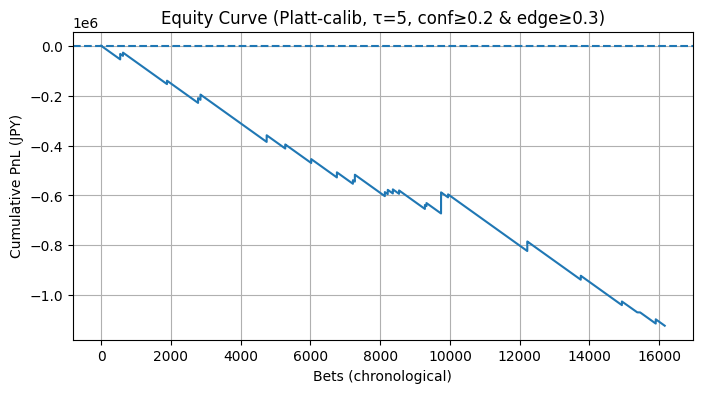

In [60]:


# ---- Monkey‑patch ROIAnalyzer so it uses BoatRaceDataset2 (MTL) ----------
from types import MethodType
from BoatRaceDataset2 import BoatRaceDataset as BR2Dataset
from torch.utils.data import DataLoader

class _EvalDatasetMTL(torch.utils.data.Dataset):
    """
    Wrap BoatRaceDataset2 but return only 4 items (ctx, boats, lane_ids, ranks)
    so that roi_util.py can stay unchanged.
    """
    def __init__(self, df):
        self.ds = BR2Dataset(df)
    def __len__(self):
        return len(self.ds)
    def __getitem__(self, idx):
        ctx, boats, lane_ids, ranks, _, _ = self.ds[idx]
        return ctx, boats, lane_ids, ranks

def _create_loader_mtl(self, df_eval: pd.DataFrame):
    """Replacement for ROIAnalyzer._create_loader (MTL‑aware)."""
    df = self.preprocess_df(df_eval, self.scaler, self.num_cols)
    ds_eval = _EvalDatasetMTL(df)
    loader = DataLoader(ds_eval, batch_size=self.batch_size, shuffle=False)
    lanes_np = df[["first_lane", "second_lane", "third_lane"]].to_numpy(dtype=np.int64) - 1
    return loader, df, lanes_np

import roi_util as _roi_util_mod
_roi_util_mod.ROIAnalyzer._create_loader = _create_loader_mtl

from roi_util import ROIAnalyzer


"""
Fetch last 90‑day races, compute edge & Kelly strategy,
and output ROI / PnL statistics + equity curve.
"""
today = dt.date.today()
# 2025年1月1日以降のデータを取得する場合は、以下の行を変更してください。
start_date = dt.date(2025, 1, 1)
# start_date = today - dt.timedelta(days=20)

query = f"""
    SELECT * FROM feat.eval_features3
    WHERE race_date BETWEEN '{start_date}' AND '{today}'
"""
df_recent = pd.read_sql(query, conn)
print(df_recent)

df_recent.drop(columns=exclude, inplace=True, errors="ignore")

if df_recent.empty:
    print("[simulate] No rows fetched for last 3 months.")

print(f"[simulate] Loaded {len(df_recent)} rows ({start_date} – {today}).")
print(f"columns: {', '.join(df_recent.columns)}")

# ---- wrap MTL model so ROIAnalyzer sees only rank scores ----
class _RankOnly(nn.Module):
    """Adapter: forward() returns rank_pred tensor only, temperature-scaled."""
    def __init__(self, base):
        super().__init__()
        self.base = base
    def forward(self, *args, **kwargs):
        _, rank_pred, _ = self.base(*args, **kwargs)
        return rank_pred / TEMPERATURE

# ----- metrics & equity (best‑practice defaults) -----
rank_model = _RankOnly(model).to(device)
analyzer = ROIAnalyzer(model=rank_model, scaler=scaler,
                       num_cols=NUM_COLS, device=device)

df_trifecta_met = analyzer.compute_metrics_dataframe(
    df_eval=df_recent,
    tau=5.0,                 # ← Fractional‑Kelly倍率を上げてユニットを実用域へ
    calibrate="platt",        # ← Platt scaling で確率をキャリブレーション
    bet_type="trifecta",  # ← 三連単を対象にする
)

df_trifecta_met.to_csv("artifacts/metrics_trifecta.csv", index=False)

# hitが True の行だけを抽出
df_trifecta_met_hit = df_trifecta_met[df_trifecta_met["hit"] == True]
df_trifecta_met_hit.to_csv("artifacts/metrics_trifecta_hit.csv", index=False)


df_trifecta_eq = ROIAnalyzer.compute_equity_curve(
    df_trifecta_met,
    bet_unit=1,
    bet_mode="kelly",
    min_conf=1.0,  # ← Platt scaling でキャリブレーション後の信頼度
    min_edge=0.0,
    min_kelly=0.00,
    max_units=15,
    use_conf_factor=True
)
df_trifecta_eq.to_csv("artifacts/equity_curve_trifecta.csv", index=False)


ROIAnalyzer.plot_equity_curve(
    df_trifecta_eq,
    title="Equity Curve (Platt‑calib, τ=5, conf≥0.2 & edge≥0.3)",
    use_jpy=True
)

In [61]:

# --- 予測でも「自信度」と「正解三連単の順位」を評価し、CSV に記録 ---
print("[predict] Evaluating confidence & trifecta rank on recent predictions…")

# ROIAnalyzer の前処理（スケーリング等）をそのまま使ってローダを作成
loader_eval, _df_eval_proc, _lanes = analyzer._create_loader(df_recent)

# 既に上で用意した rank_model は「rank_pred だけ」を返すアダプタ
model.eval(); rank_model.eval()
all_scores, all_ranks = [], []
with torch.no_grad():
    for ctx, boats, lane_ids, ranks in loader_eval:
        ctx, boats, lane_ids = ctx.to(device), boats.to(device), lane_ids.to(device)
        scores = rank_model(ctx, boats, lane_ids)  # (B,6) already scaled
        all_scores.append(scores.cpu())
        all_ranks.append(ranks)

all_scores = torch.cat(all_scores, dim=0)   # (N,6)
all_ranks  = torch.cat(all_ranks,  dim=0)   # (N,6)

[predict] Evaluating confidence & trifecta rank on recent predictions…


/Users/keiichiro/workspace/boat_racing/model/roi_util.py:40: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[bool_cols] = df[bool_cols].fillna(False).astype(bool)


In [ ]:


# ---------- helper metrics ----------
def top1_accuracy(scores: torch.Tensor, ranks: torch.Tensor) -> float:
    pred_top1 = scores.argmax(dim=1)
    true_top1 = (ranks == 1).nonzero(as_tuple=True)[1]
    return (pred_top1 == true_top1).float().mean().item()

def trifecta_hit_rate(scores: torch.Tensor, ranks: torch.Tensor) -> float:
    """
    予測スコア上位3艇の順番が、実際の1〜3着と完全一致する割合。
    """
    pred_top3 = torch.topk(scores, k=3, dim=1).indices
    true_top3 = torch.topk(-ranks, k=3, dim=1).indices  # 小さい順に 1→3 着
    hit = [p.tolist() == t.tolist() for p, t in zip(pred_top3, true_top3)]
    return float(sum(hit) / len(hit)) if len(hit) else float("nan")

# --- Baseline: always predict trifecta 1-2-3 (lanes 1→2→3) ------------------
def constant_123_trifecta_hit(ranks: torch.Tensor) -> float:
    """
    Hit‑rate when always predicting trifecta 1‑2‑3 in order.
    """
    true_top3 = torch.topk(-ranks, k=3, dim=1).indices   # (B,3)
    baseline  = torch.tensor([0, 1, 2], dtype=torch.long, device=ranks.device)
    return (true_top3 == baseline).all(dim=1).float().mean().item()

def baseline123_position_accuracy(ranks: torch.Tensor, pos: int) -> float:
    """
    Baseline per‑position accuracy when assuming boat pos finishes pos‑th.
    pos ∈ {1,2,3}
    """
    true_idx = (ranks == pos).float().argmax(dim=1)          # (B,)
    baseline_idx = torch.tensor(pos - 1, dtype=torch.long, device=ranks.device)
    return (true_idx == baseline_idx).float().mean().item()

def baseline123_top3_unordered_hit(ranks: torch.Tensor) -> float:
    """
    Order‑agnostic hit‑rate when always predicting the set {1,2,3}.
    """
    true_top3 = torch.topk(-ranks, k=3, dim=1).indices
    hit = [set(t.tolist()) == {0,1,2} for t in true_top3]
    return float(sum(hit) / len(hit))

from itertools import permutations

def get_trifecta_rank(scores: torch.Tensor, true_ranks: torch.Tensor) -> list[int]:
    """真の三連単が、全 120 通りの予測候補の中で何番目か（1 始まり）を返す。"""
    perms = list(permutations(range(6), 3))
    res = []
    for sc, tr in zip(scores, true_ranks):
        true_top3 = [i for i, r in enumerate(tr.tolist()) if r <= 3]
        true_top3_sorted = [x for _, x in sorted(zip(tr[true_top3], true_top3))]
        perm_scores = [(p, sc[list(p)].sum().item()) for p in perms]
        perm_scores.sort(key=lambda x: x[1], reverse=True)
        for idx, (p, _) in enumerate(perm_scores):
            if list(p) == true_top3_sorted:
                res.append(idx + 1)
                break
        else:
            res.append(len(perms) + 1)
    return res

# --- Added: strict (order-respecting) trifecta rank ---
def get_trifecta_rank_ordered(scores: torch.Tensor, true_ranks: torch.Tensor) -> list[int]:
    perms = list(permutations(range(6), 3))
    res = []
    exp_scores = torch.exp(scores)         # (N,6)
    for es, tr in zip(exp_scores, true_ranks):
        # true indices for 1st→3rd in correct order
        ordered_true = sorted(range(6), key=lambda i: tr[i].item())[:3]

        denom0 = es.sum().item()
        perm_probs = []
        for p in perms:
            p0, p1, p2 = p
            denom1 = denom0
            denom2 = denom1 - es[p0].item()
            denom3 = denom2 - es[p1].item()
            prob = (es[p0] / denom1) * (es[p1] / denom2) * (es[p2] / denom3)
            perm_probs.append((p, prob.item()))

        perm_probs.sort(key=lambda x: x[1], reverse=True)
        for idx, (p, _) in enumerate(perm_probs):
            if list(p) == ordered_true:
                res.append(idx + 1)        # 1‑based
                break
        else:
            res.append(len(perms) + 1)     # fallback (shouldn't happen)
    return res


# ---------- extra metrics ----------
def top3_unordered_hit_rate(scores: torch.Tensor, ranks: torch.Tensor) -> float:
    """
    True if the model's top‑3 set matches the actual top‑3 set (order‑agnostic).
    """
    pred_top3 = torch.topk(scores, k=3, dim=1).indices
    true_top3 = torch.topk(-ranks, k=3, dim=1).indices
    hit = [(set(p.tolist()) == set(t.tolist())) for p, t in zip(pred_top3, true_top3)]
    return float(sum(hit) / len(hit))

def mean_reciprocal_rank(scores: torch.Tensor, ranks: torch.Tensor) -> float:
    """
    MRR of predicting the winner (1着).
    """
    order = scores.argsort(dim=1, descending=True)          # (B,6)
    true_winner_idx = (ranks == 1).nonzero(as_tuple=True)[1]
    rank_pos = (order == true_winner_idx.unsqueeze(1)).nonzero(as_tuple=True)[1] + 1  # 1‑based
    return (1.0 / rank_pos.float()).mean().item()

def spearman_corr(scores: torch.Tensor, ranks: torch.Tensor) -> float:
    """
    Average per‑race Spearman rank correlation between predicted and true rank orders.
    """
    pred_rank = scores.argsort(dim=1, descending=True).argsort(dim=1).float() + 1  # 1..6
    true_rank = ranks.float()
    d = pred_rank - true_rank
    rho = 1 - 6 * (d ** 2).sum(dim=1) / (6 * (6**2 - 1))
    return rho.mean().item()

def trifecta_rank_pl(scores: torch.Tensor, true_ranks: torch.Tensor) -> list[int]:
    """Plackett-Luce 確率で並べた三連単順位を返す（exact order）。"""
    perms = list(permutations(range(6), 3))
    exp_s = torch.exp(scores)
    res = []
    for sc, tr in zip(exp_s, true_ranks):
        # 真の順序 (1→2→3 着)
        idx123 = [x for _, x in sorted(zip(tr.tolist(), range(6)))][:3]
        # PL確率を計算
        probs = []
        for p in perms:
            # 第1着
            denom1 = sc.sum()
            p1 = sc[p[0]] / denom1
            # 第2着
            denom2 = (sc.sum() - sc[p[0]])
            p2 = sc[p[1]] / denom2
            # 第3着
            denom3 = (sc.sum() - sc[p[0]] - sc[p[1]])
            p3 = sc[p[2]] / denom3
            probs.append((p, (p1*p2*p3).item()))
        probs.sort(key=lambda x: x[1], reverse=True)
        rank = next(i for i,(p,_) in enumerate(probs) if list(p)==idx123) + 1
        res.append(rank)
    return res


# --- 5レースだけ抜き出して順位を表示 ---
new_df = pd.DataFrame(columns=["race_index", "true_order", "match_index"])

for i in range(0, len(all_scores), 120):  # 129〜133 レースを表示
    sc   = all_scores[i]
    true = all_ranks[i]

    ordered_true = sorted(range(6), key=lambda k: true[k].item())[:3]
    print(f"\nRace {i}")
    print(" true order :", ordered_true)

    # PL順で上位5件
    perms = list(permutations(range(6), 3))
    es = torch.exp(sc)
    denom0 = es.sum().item()
    perm_probs = []
    for p in perms:
        d2 = denom0 - es[p[0]].item()
        d3 = d2     - es[p[1]].item()
        prob = (es[p[0]] / denom0) * (es[p[1]] / d2) * (es[p[2]] / d3)
        perm_probs.append((p, prob.item()))
    perm_probs.sort(key=lambda x: x[1], reverse=True)
    print(" top-5 by PL :", perm_probs[:5])

    # 正解三連単が何番目に出たか
    true_order_tuple = tuple(ordered_true)
    match_index = next((j for j, (order, _) in enumerate(perm_probs) if order == true_order_tuple), -1)
    print(f'matched: {match_index + 1}')

    # new_dfに追加
    new_df.loc[len(new_df)] = {
        "race_index": i,
        "true_order": ordered_true,
        "match_index": match_index + 1  # 1-indexed にして表示
    }
    
new_df.to_csv("artifacts/predicted_trifecta_order.csv", index=False)
# ## ---- compute & print ----
# score_vars = all_scores.var(dim=1)
# tri_ranks  = get_trifecta_rank(all_scores, all_ranks)
# tri_ranks_order = get_trifecta_rank_ordered(all_scores, all_ranks)
# mean_tri_order  = float(np.mean(tri_ranks_order)) if len(tri_ranks_order) else float("nan")

# acc_top1   = top1_accuracy(all_scores, all_ranks)
# acc_tri3   = trifecta_hit_rate(all_scores, all_ranks)
# mean_var   = score_vars.mean().item()
# median_var = score_vars.median().item()
# mean_tri   = float(np.mean(tri_ranks)) if len(tri_ranks) else float("nan")

# # ---- compute new metrics ----
# hit_top3_unordered = top3_unordered_hit_rate(all_scores, all_ranks)
# mrr_winner        = mean_reciprocal_rank(all_scores, all_ranks)
# rho_spearman      = spearman_corr(all_scores, all_ranks)

# # ---- baseline metrics (constant 1‑2‑3) ----
# tri123_hit      = constant_123_trifecta_hit(all_ranks)
# base_pos1       = baseline123_position_accuracy(all_ranks, 1)
# base_pos2       = baseline123_position_accuracy(all_ranks, 2)
# base_pos3       = baseline123_position_accuracy(all_ranks, 3)
# base_top1       = base_pos1                                   # same as pos1
# base_top3_unord = baseline123_top3_unordered_hit(all_ranks)

# # --- per-position accuracy (model) ---
# def position_accuracy(ranks: torch.Tensor, scores: torch.Tensor, pos: int) -> float:
#     """
#     Accuracy for predicting which boat finishes pos‑th.
#     """
#     # Model's prediction: which boat is pos-th in predicted ranking
#     pred_rank = scores.argsort(dim=1, descending=True).argsort(dim=1) + 1
#     pred_idx = (pred_rank == pos).float().argmax(dim=1)
#     true_idx = (ranks == pos).float().argmax(dim=1)
#     return (pred_idx == true_idx).float().mean().item()

# acc_pos1 = position_accuracy(all_ranks, all_scores, 1)
# acc_pos2 = position_accuracy(all_ranks, all_scores, 2)
# acc_pos3 = position_accuracy(all_ranks, all_scores, 3)

# print(f"[predict] N={len(all_scores)}")
# print(f"  • Top‑1 Acc              : {acc_top1:.3f}   (baseline {base_top1:.3f})")
# print(f"  • Pos1/2/3 Acc           : {acc_pos1:.3f}/{acc_pos2:.3f}/{acc_pos3:.3f} "
#       f"(baseline {base_pos1:.3f}/{base_pos2:.3f}/{base_pos3:.3f})")
# print(f"  • Top‑3 unordered Hit    : {hit_top3_unordered:.3f}   (baseline {base_top3_unord:.3f})")
# print(f"  • Trifecta Hit           : {acc_tri3:.3f}   (baseline {tri123_hit:.3f})")
# print(f"  • Winner MRR             : {mrr_winner:.3f}")
# print(f"  • Spearman ρ             : {rho_spearman:.3f}")
# print(f"  • Score variance (mean/median): {mean_var:.4f} / {median_var:.4f}")
# print(f"  • Avg rank of true trifecta (unordered) : {mean_tri:.2f}")
# print(f"  • Avg rank of true trifecta (strict)    : {mean_tri_order:.2f}")

# # ---- CSV に追記保存 ----
# import csv, os
# os.makedirs("artifacts", exist_ok=True)
# metrics_path = "artifacts/predict_metrics_recent.csv"
# write_header = not os.path.exists(metrics_path)
# with open(metrics_path, "a", newline="") as f:
#     w = csv.writer(f)
#     if write_header:
#         w.writerow(["date", "n_races",
#                     "top1_acc", "pos1_acc", "pos2_acc", "pos3_acc",
#                     "top3unordered_hit", "trifecta_hit",
#                     "baseline123_hit", "baseline123_top1",
#                     "baseline123_pos1", "baseline123_pos2", "baseline123_pos3",
#                     "baseline123_top3unordered",
#                     "winner_mrr", "spearman_rho",
#                     "var_mean", "var_median", "tri_rank_mean",
#                     "tri_rank_order_mean"])
#     w.writerow([str(today), len(all_scores),
#                 acc_top1, acc_pos1, acc_pos2, acc_pos3,
#                 hit_top3_unordered, acc_tri3,
#                 tri123_hit, base_top1,
#                 base_pos1, base_pos2, base_pos3,
#                 base_top3_unord,
#                 mrr_winner, rho_spearman,
#                 mean_var, median_var, mean_tri, mean_tri_order])
# print(f"[saved] {metrics_path}")

KeyboardInterrupt: 

In [67]:


# --------------------------------------------------------------------------
#  グループ Ablation: 重要列を 5～6 個まとめてドロップして val_nll を比較
# --------------------------------------------------------------------------



def permute_importance(model, dataset, device="cpu", cols=None):
    """
    Permutation importance: 各特徴量列をランダムに permute して val_nll の悪化量を調べる
    """
    base_loss = evaluate_model(model, dataset, device)

    # ----- 列リストを決める --------------------------------------------------
    # cols=None なら「データフレームに存在する “使えそうな” 全列」を対象にする
    if cols is None:
        # 予測ターゲットやキー列は除外
        skip = {"race_key", "race_date"}
        # rank 列（教師信号）や欠損だらけの列も除外
        skip |= {c for c in dataset.f.columns if c.endswith("_rank")}
        cols = [c for c in dataset.f.columns if c not in skip]

    importances: dict[str, float] = {}
    df_full = dataset.f

    for col in cols:
        # --- その列だけランダムに permute ---
        shuffled = df_full.copy()
        shuffled[col] = np.random.permutation(shuffled[col].values)
        tmp_ds = BoatRaceDataset(shuffled)
        loss = evaluate_model(model, tmp_ds, device)
        importances[col] = loss - base_loss   # 悪化分 (大 → 重要)
    return importances

def run_ablation_groups(
    df_full: pd.DataFrame,
    group_size: int = 6,
    epochs: int = 5,
    seed: int = 42,
    device: str = "cpu",
):
    """
    全特徴量をランダムに group_size 個ずつ束ね、
    そのグループを丸ごと削除して再学習 → val_nll を返す。

    戻り値: list[tuple[list[str], float]]
        (ドロップした列リスト, val_nll) を val_nll 昇順で並べたもの
    """
    random.seed(seed)

    essential_cols = set(NUM_COLS)          # ctx 用の連続値
    for l in range(1, 7):
        essential_cols.update({
            f"lane{l}_exh_time",
            f"lane{l}_st",
            f"lane{l}_weight",
            f"lane{l}_bf_course",
            f"lane{l}_fs_flag",
            f"lane{l}_racer_id",
            f"lane{l}_racer_name",
            f"lane{l}_racer_age",
            f"lane{l}_racer_weight",
        })
    # --- 対象列を決める（ターゲット & キー列は除外） ---
    skip = {"race_key", "race_date"}
    skip |= {c for c in df_full.columns if c.endswith("_rank")}
    skip |= essential_cols  
    skip |= {c for c in df_full.columns if c.endswith("_rank")}
    cols = [c for c in df_full.columns if c not in skip]
    random.shuffle(cols)

    groups = [cols[i : i + group_size] for i in range(0, len(cols), group_size)]
    results = []

    latest_date = pd.to_datetime(df_full["race_date"]).dt.date.max()
    cutoff = latest_date - dt.timedelta(days=90)

    for g in groups:
        df_drop = df_full.drop(columns=g)

        ds_tr = BoatRaceDataset(df_drop[df_drop["race_date"] < cutoff])
        ds_va = BoatRaceDataset(df_drop[df_drop["race_date"] >= cutoff])

        ld_tr = DataLoader(ds_tr, batch_size=256, shuffle=True)
        ld_va = DataLoader(ds_va, batch_size=512)

        model = DualHeadRanker().to(device)
        opt = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=5e-5)

        for _ in range(epochs):
            model.train()
            for ctx, boats, lane_ids, ranks, st_true, st_mask in ld_tr:
                ctx, boats = ctx.to(device), boats.to(device)
                lane_ids, ranks = lane_ids.to(device), ranks.to(device)
                st_true, st_mask = st_true.to(device), st_mask.to(device)
                st_pred, scores = model(ctx, boats, lane_ids)
                pl_loss = pl_nll(scores, ranks)
                mse_st = ((st_pred - st_true) ** 2 * st_mask.float()).sum() / st_mask.float().sum()
                loss = pl_loss + LAMBDA_ST * mse_st
                opt.zero_grad(); loss.backward(); opt.step()

        val_loss = evaluate_model(model, ds_va, device)
        results.append((g, val_loss))

    return sorted(results, key=lambda x: x[1])  # 小さい順に重要

print("▼ Permutation importance (ALL features)")
all_imp = permute_importance(model, ds_val, device)
imp_path = "artifacts/perm_importance_all.csv"
pd.Series(all_imp).sort_values(ascending=False).to_csv(imp_path)
print(f"[saved] {imp_path}")

# ② グループ Ablation
print("▼ Group ablation (drop 6 cols each)")
ab_results = run_ablation_groups(df, group_size=6,
                                    epochs=5, device=device)
abl_path = "artifacts/ablation_results.csv"
with open(abl_path, "w", newline="") as f:
    import csv
    w = csv.writer(f); w.writerow(["dropped_cols", "val_nll"])
    for cols, v in ab_results:
        w.writerow(["|".join(cols), f"{v:.6f}"])
print(f"[saved] {abl_path}")

▼ Permutation importance (ALL features)
[saved] artifacts/perm_importance_all.csv
▼ Group ablation (drop 6 cols each)


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1536x16 and 14x160)

In [ ]:


# ────────────────────────────────────────────────────────────────
# ① SHAP Interaction を計算するユーティリティ
# ----------------------------------------------------------------
import shap, seaborn as sns, matplotlib.pyplot as plt
import numpy as np, torch, os

# ① 先頭付近に追加
class _ModelForShap(torch.nn.Module):
    """lane_ids を float → long に戻してから元モデルへ"""
    def __init__(self, base):
        super().__init__()
        self.base = base
    def forward(self, ctx, boats, lane_ids_f):
        return self.base(ctx, boats, lane_ids_f.long())

def shap_interaction_heatmap(model, loader_val,
                             device="cpu",
                             n_samples=128,
                             save_prefix="artifacts/shap"):
    """
    ctx(環境6変数) と boat(各艇の3変数: exh_time/st/weight) の
    相互作用を DeepExplainer で可視化する。

    例：
      - フォーム(winrate_30d_l*) × 風速(wind_speed)
      - 重量(weight)           × 追い風(wind_sin<0)
    """
    model.eval()
    os.makedirs(os.path.dirname(save_prefix), exist_ok=True)

    # ---- まずバッチを取り出して n_samples だけ切り出す ----
    ctx, boats, lane_ids, _, _, _ = next(iter(loader_val))
    ctx, boats, lane_ids = ctx[:n_samples].to(device), \
                           boats[:n_samples].to(device), \
                           lane_ids[:n_samples].to(device)

    # ---- SHAP DeepExplainer (多入力モデル) -------------------
    model_wrap = _ModelForShap(model).to(device)
    lane_ids_f = lane_ids.float()
    explainer = shap.DeepExplainer(model_wrap, [ctx, boats, lane_ids_f])
    # DeepExplainer はバージョンにより shap_interaction_values を
    # 実装していないため try / except でフォールバック
    try:
        shap_int = explainer.shap_interaction_values([ctx, boats, lane_ids_f])
        use_exact = True
    except AttributeError:
        # ---------- 近似的な Interaction 行列を自前計算 ----------
        #   |SHAP_i * SHAP_j| の平均 ≈ 交互作用の強さとみなす
        try:
            shap_vals = explainer.shap_values([ctx, boats, lane_ids_f], check_additivity=False)
        except AssertionError:
            # DeepExplainer が sum-consistency でコケたときは GradientExplainer に切替
            explainer = shap.GradientExplainer(model_wrap, [ctx, boats, lane_ids_f])
            shap_vals = explainer.shap_values([ctx, boats, lane_ids_f], check_additivity=False)
        ctx_sv   = np.asarray(shap_vals[0])        # shape (B,C)
        boat_sv  = np.asarray(shap_vals[1])        # shape (B,6,F)

        # 1) 環境 × 環境
        ctx_int_mat = np.mean(np.abs(ctx_sv[:, :, None] * ctx_sv[:, None, :]), axis=0)  # (C,C)

        # 2) Boat × Boat (lane 平均)
        #    boat_sv: (B,6,F) → (B,6,F,1) * (B,6,1,F) → (B,6,F,F)
        boat_pair = np.abs(boat_sv[:, :, :, None] * boat_sv[:, :, None, :])  # (B,6,F,F)
        boat_int_mat = boat_pair.mean((0,1))                                 # lane & batch 平均 → (F,F)

        # 3) 環境 × Boat
        cross_raw = np.abs(ctx_sv[:, :, None, None] * boat_sv[:, None, :, :])  # (B,C,6,F)
        cross_int = cross_raw.mean((0,2))                                       # (C,F)
        use_exact = False
    else:
        # ---------- 正確な Interaction (DeepExplainer 対応版) ----------
        # shap_int は list: [ctx_int, boat_int, lane_int]
        #   ctx_int  : (B, C, C)
        #   boat_int : (B, 6, F, 6, F)
        ctx_int_mat  = np.abs(shap_int[0]).mean(0)                     # (C,C)
        boat_int_raw = np.abs(shap_int[1])                             # (B,6,F,6,F)
        boat_int_mat = boat_int_raw.mean((0,1,3))                      # (F,F)

        cross_int    = boat_int_raw.mean((0,3))                        # (C,F)
    msg = "exact" if use_exact else "approx"
    print(f"[info] SHAP interaction mode: {msg}")

        # --- ensure ctx_int_mat is 2‑D (Seaborn heatmap requirement) ---
    while ctx_int_mat.ndim > 2:
        ctx_int_mat = ctx_int_mat.mean(0)

    # ---- ヒートマップ表示 ------------------------------------
    # (A) 環境どうし
    ctx_feat_names = ["air_temp","wind_speed","wave_height",
                      "water_temp","wind_sin","wind_cos"]
    plt.figure(figsize=(6,5))
    sns.heatmap(ctx_int_mat, annot=False, square=True,
                xticklabels=ctx_feat_names, yticklabels=ctx_feat_names,
                cmap="coolwarm", center=0)
    plt.title("SHAP Interaction – Environment × Environment")
    plt.tight_layout()
    plt.savefig(f"{save_prefix}_ctx_ctx.png", dpi=180)
    plt.show()

    # (B) Boat どうし
        # --- ensure boat_int_mat is 2‑D ---
    while boat_int_mat.ndim > 2:
        # 平均を最後の軸に取って次元を潰す
        boat_int_mat = boat_int_mat.mean(-1)
    # feature 数とラベル長が合わなければ自動補完
    
    boat_feat_names = ["exh_time","st","weight"]         # ← BoatRaceDataset が渡す順
    F = boat_int_mat.shape[0]
    if len(boat_feat_names) != F:
        boat_feat_names = [f"feat{i}" for i in range(F)]
    plt.figure(figsize=(4,4))
    sns.heatmap(boat_int_mat, annot=False, square=True,
                xticklabels=boat_feat_names, yticklabels=boat_feat_names,
                cmap="coolwarm", center=0)
    plt.title("SHAP Interaction – Boat × Boat (lane平均)")
    plt.tight_layout()
    plt.savefig(f"{save_prefix}_boat_boat.png", dpi=180)
    plt.show()

    # (C) 環境 × Boat
    while cross_int.ndim > 2:
        # 平均を第1軸に取りつつ次元を潰す
        cross_int = cross_int.mean(1)
    plt.figure(figsize=(5,4))
    sns.heatmap(cross_int, annot=False,
                yticklabels=ctx_feat_names,
                xticklabels=boat_feat_names,
                cmap="coolwarm", center=0)
    plt.title("SHAP Interaction – Environment × Boat")
    plt.xlabel("Boat feature"), plt.ylabel("Env feature")
    plt.tight_layout()
    plt.savefig(f"{save_prefix}_ctx_boat.png", dpi=180)
    plt.show()

    # ---- 具体的なペアの数値を抜き出す例 ----------------------
    # w_speed_idx   = ctx_feat_names.index("wind_speed")
    # headwind_idx  = ctx_feat_names.index("wind_sin")   # sin<0 が追い風
    # weight_idx    = boat_feat_names.index("weight")

    # form_idxs = [i for i,n in enumerate(boat_feat_names) if "winrate" in n]  # 例
    # form_wspeed = cross_int[w_speed_idx, weight_idx]
    # weight_head = cross_int[headwind_idx, weight_idx]
    # print(f"[form × wind_speed] interaction ≈ {form_wspeed:.4f}")
    # print(f"[weight × headwind] interaction ≈ {weight_head:.4f}")

# ─── 呼び出し ───
shap_interaction_heatmap(model, loader_val, device=device, n_samples=128)

In [ ]:


# ============================================================
# ④ ── 「勾配が流れているか」を瞬時に確認する Snippet
#       （エポック終了後 1 回だけ走らせれば十分）
# ------------------------------------------------------------

# ============================================================
 
 # ============================================================
 # ⑤ ── 超小規模データで「過学習できるか」テスト関数
 #       必要時に呼び出して 0.1 以下まで loss が落ちるか確認
 # -----------------------------------------------------------


# ---- tiny データで特徴量の分散を確認 -----------------------
tiny_df = df.sample(10, random_state=1).reset_index(drop=True)
num_cols = tiny_df.select_dtypes(include="number").columns

# (1) 行間（=レース間）での分散
print("► 行間 variance (should be >0):")
print(tiny_df[num_cols].var().nsmallest(10))

# (2) 同一レース内（= 6 艇間）での分散
def per_race_var(col):
    return tiny_df.groupby("race_key")[col].var().mean()

per_race = {c: per_race_var(c) for c in num_cols}
print("\n► 6 艇間 variance:")
print(sorted(per_race.items(), key=lambda x: x[1])[:10])

# ---- 呼び方例 ----
overfit_tiny(df, device)
# ============================================================

In [ ]:


torch.save({
    "state_dict": model.state_dict(),
    "scaler": scaler_filename,
    "venue2id": venue2id,
    # "race_type2id": race_type2id
}, "cplnet_checkpoint.pt")

In [ ]:


# ============================================================
# ★ 予測用スクリプト（直近3ヶ月データを使って予測） ★
# ============================================================



def predict_latest_3months():
    import datetime as dt
    today = dt.date.today()
    three_months_ago = today - dt.timedelta(days=90)

    query = f"""
        SELECT * FROM feat.train_features
        WHERE race_date BETWEEN '{three_months_ago}' AND '{today}'
    """
    df_pred = pd.read_sql(query, conn)
    print(f"[predict] Loaded {len(df_pred)} rows for prediction")

    # --- 前処理 ---
    df_pred["wind_dir_rad"] = np.deg2rad(df_pred["wind_dir_deg"])
    df_pred["wind_sin"] = np.sin(df_pred["wind_dir_rad"])
    df_pred["wind_cos"] = np.cos(df_pred["wind_dir_rad"])
    df_pred[NUM_COLS] = scaler.transform(df_pred[NUM_COLS])

    bool_cols = [c for c in df_pred.columns if c.endswith("_fs_flag")]
    df_pred[bool_cols] = df_pred[bool_cols].fillna(False)
    rank_cols = [f"lane{l}_rank" for l in range(1, 7)]
    df_pred[rank_cols] = df_pred[rank_cols].fillna(7).astype("int32")

    pred_ds = BoatRaceDataset(df_pred)
    pred_loader = DataLoader(pred_ds, batch_size=1)

    model.eval()
    for i, (ctx, boats, lane_ids, _) in enumerate(pred_loader):
        ctx, boats, lane_ids = ctx.to(device), boats.to(device), lane_ids.to(device)
        with torch.no_grad():
            scores = model(ctx, boats, lane_ids)  # (1,6)
            pred_rank = scores.squeeze().argsort(descending=True).argsort() + 1
            # print(f"[{i:03d}] 予測順位:", pred_rank.cpu().numpy())

    # --- 追加: 固定着順との比較評価 ---
    def evaluate_against_fixed_ranks(pred_loader):
        """
        着順 [1,2,3,4,5,6] を常に予測したと仮定した場合と、モデルの予測を比較する
        """
        model_correct = [0] * 6
        fixed_correct = [0] * 6
        total = 0

        model.eval()
        for _, (ctx, boats, lane_ids, true_ranks) in enumerate(pred_loader):
            ctx, boats, lane_ids = ctx.to(device), boats.to(device), lane_ids.to(device)
            true_ranks = true_ranks.to(device)

            with torch.no_grad():
                scores = model(ctx, boats, lane_ids)
                pred_rank = scores.squeeze().argsort(descending=True).argsort() + 1  # (6,)

            total += 1
            for i in range(6):
                # モデルがその艇の着順を当てたか
                if pred_rank[i].item() == true_ranks[0][i].item():
                    model_correct[i] += 1
                # 固定予測 [1,2,3,4,5,6] を使った場合
                if (i + 1) == true_ranks[0][i].item():
                    fixed_correct[i] += 1

        print("\n--- モデル vs 固定着順 予測精度 ---")
        for i in range(6):
            print(f"{i+1}着: モデル={model_correct[i]/total:.3f}  固定={fixed_correct[i]/total:.3f}  (正解数: モデル={model_correct[i]} 固定={fixed_correct[i]})")

    evaluate_against_fixed_ranks(pred_loader)

# 呼び出し例

plot_learning_curve(df, device)
predict_latest_3months()

# ======================================================================